In [3]:
import pandas as pd
import os 
import numpy as np
import re
import random
import tomotopy as tp
import sys
import pickle
import time

In [4]:
input_path = "abstracts_processed.csv"
with open(input_path, "rb") as fp:   
    # Unpickling
    documents = pickle.load(fp)

# Experiment 1 - HDP

In [3]:
## Setting the hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
initial_k = 2
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
min_df=0 # minimum document frequency of words. Words with a smaller document frequency than min_df are excluded from the model. The default value is 0, which means no words are excluded
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = 0.1 # hyperparameter of Dirichlet distribution for document-topic
eta = 0.01 # hyperparameter of Dirichlet distribution for topic-word
gamma = 0.1 # concentration coeficient of Dirichlet Process for table-topic
transform = None # a callable object to manipulate arbitrary keyword arguments for a specific topic model
seed = 41 # random seed
model_burn_in = 500 
train_updates = 10000
train_iter = 10
save_path = "hdp_model.bin" #.bin format

In [14]:
model = tp.HDPModel(tw=tw, min_cf=min_cf, min_df=min_df, rm_top=rm_top, initial_k=initial_k, alpha=alpha, 
                    eta=eta, gamma=gamma, transform=transform)

In [15]:
# adding documents to the model 
for doc in documents: model.add_doc(doc)

In [16]:

start = time.time()
# training**
model.burn_in = model_burn_in
# initialising 
model.train(iter=0)
print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
print('Removed top words:', model.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
# actual training 
t = []
LLs = []
for i in range(0, train_updates, train_iter):
    model.train(train_iter)
    if i%1000==0:print('Iteration: {}'.format(i))
    t.append(i)
    LLs.append(model.ll_per_word)

end = time.time()
print("Time elapsed: "+ str(round(end - start,1))+" s")

Training...


Num docs: 20494 , Vocab size: 42219 , Num words: 2045097
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


In [17]:
model.summary()

<Basic Info>
| HDPModel (current version: 0.9.1)
| 20494 docs, 2045097 words
| Total Vocabs: 69312, Used Vocabs: 42219
| Entropy of words: -8.71136
| Removed Vocabs: use model result studi base
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.33705
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| initial_k: 150 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.1 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 205194031 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (concentration coeficient of Dirichlet Process f

In [ ]:
def train_HDP()

# Experiment 2 - Online HDP

In [5]:
from gensim.models import HdpModel
from gensim.corpora import Dictionary
random.seed = 11 #set the seed right away

In [6]:
# Train and test (80-20)
print(len(documents))
set1_size = int(0.3*len(documents)) 
set2_size = int(0.7*len(documents)) 

random.shuffle(documents)

set1_docs = documents[0:set1_size]
set2_docs = documents[set1_size:]

len(set1_docs) + len(set2_docs) == len(documents)

20494


True

In [197]:
# Preparing the input in gensim format 
from copy import deepcopy

def prepare_gensim_input(docs, old_dict=None):
    # TODO: add possibility to remove extremes (too frequent/rare words)
    dictionary = Dictionary(docs)
    if old_dict is not None: 
        old_dict_copy = deepcopy(old_dict)
        old_dict_copy.merge_with(dictionary)
        dictionary = old_dict_copy
    corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in docs] # bag of words corpus 
    return dictionary, corpus

In [198]:
dictionary1, corpus1 = prepare_gensim_input(set1_docs)

### OHDP model

Online HDP provides <u>the speed of online variational Bayes with the modeling flexibility of the HDP</u>.<br>
The idea behind Online variational Bayes in general is to optimize the variational objective function with stochastic optimization.<br>
The challenge we face is that the existing coordinate ascent variational Bayes algorithms for the HDP require complicated approximation methods or numerical optimization. 


Look [here](https://radimrehurek.com/gensim/models/hdpmodel.html) for more.

In [59]:
# HYERARAMETERS 
alpha = 1 #(int, optional) – Second level concentration - below one leads to  more sparse solutions
gamma = 1 #(int, optional) – First level concentration
eta = 0.01 #(float, optional) – The topic Dirichlet

In [294]:
start = time.time()
hdp = HdpModel(corpus1, dictionary1, max_chunks=None, 
               max_time=None, chunksize=256, kappa=1.0, tau=64.0, 
               K=15, T=150, alpha=alpha, gamma=gamma, eta=eta, scale=1.0, 
               var_converge=0.0001, outputdir=None, random_state=None)
end = time.time()

print("Time elapsed: "+ str(round(end - start,1))+" s")

Time elapsed: 43.6 s


In [61]:
len(hdp.get_topics())

150

Print 20 topics with top 10 most probable words

In [24]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

def print_hdp_topics(model, num_words):
    hdp_topics = model.show_topics(num_topics=200, num_words=num_words)

    topics = []
    filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
    
    print("Number of topics found: "+ str(len(hdp_topics)))
    print("")
    
    for idx, topic in enumerate(hdp_topics):
        print("Topic "+str(idx)+" -------")
        t = preprocess_string(topic[1], filters)
        print(" - ".join(t))
        print("")
        topics.append(t)

In [90]:
print_hdp_topics(hdp, num_words=20)

Number of topics found: 150

Topic 0 -------
use - model - result - measur - system - base - data - studi - develop - differ - effect - method - user - test - design - increas - process - ass - approach - show

Topic 1 -------
use - model - studi - data - measur - result - base - differ - effect - show - system - increas - process - develop - st - observ - gener - also - compar - perform

Topic 2 -------
use - model - result - cpc - studi - concentr - chang - differ - activ - measur - base - effect - system - show - data - process - ec - howev - present - method

Topic 3 -------
use - model - data - studi - differ - result - measur - system - base - show - effect - gener - observ - chang - present - analysi - develop - method - compar - activ

Topic 4 -------
model - use - studi - differ - system - base - der - gener - effect - result - data - water - die - predict - measur - show - und - develop - compar - perform

Topic 5 -------
use - model - differ - effect - result - studi - base 

### In depth exploration of results 

In [82]:
def doc2topics(topics_document, num_topics):
    """ 
        topics_document : list of tuples (topic_id,weight)
        
    This function creates one row of the documents2topics matrix by 
    extracting all the topics relative to the input document. """
    
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document[1:]:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def docs2topics(model, corpus):
    """ Builds the docs2topics matrix. """
    K = len(hdp.get_topics()) # get number of topics
    topicsfordocs = [model[doc] for doc in corpus]
    matrix = pd.concat([doc2topics(doc, K) for doc in topicsfordocs]).reset_index(drop=True).fillna(0)
    return matrix

In [84]:
documents2topics = docs2topics(hdp, corpus1)

In [85]:
documents2topics.head(3)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0.0,0
1,0,0.000000,0.299465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0.0,0
2,0,0.016058,0.010585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0.0,0


In [279]:
pd.DataFrame.sum(documents2topics, axis=1)

0       0.285818
1       0.870074
2       0.389206
3       0.632547
4       0.381212
          ...   
3628    0.396735
3629    0.749237
3630    0.152837
3631    0.882028
3632    0.382239
Length: 3633, dtype: float64

In [87]:
# Which document are about topic 15
documents2topics.sort_values(15, ascending=False)[15].head(10)

3281    0.821982
221     0.789510
1372    0.556415
1071    0.544714
384     0.542751
262     0.537419
660     0.536852
400     0.532542
693     0.527859
1472    0.527007
Name: 15, dtype: float64

In [92]:
documents2topics.loc[documents2topics.idxmax(axis=1).sort_values().index]

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
2520,0,0.365875,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
2466,0,0.173794,0.0,0.0,0.0,0.084812,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
1050,0,0.788666,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
1049,0,0.748315,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
1048,0,0.789634,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
789,0,0.279983,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.000000,0.000000,0
3054,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.070701,0.000000,0.000000,0
2478,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.000000,0.088786,0.000000,0


In [102]:
# number of nonzeros in the rows 
np.mean(documents2topics.astype(bool).sum(axis=1))

1.4913294797687862

In [105]:
# number of nonzeros in the columns 
print(np.mean(documents2topics.astype(bool).sum(axis=0)))
print(np.min(documents2topics.astype(bool).sum(axis=0)))
print(np.max(documents2topics.astype(bool).sum(axis=0)))

36.12
0
1399


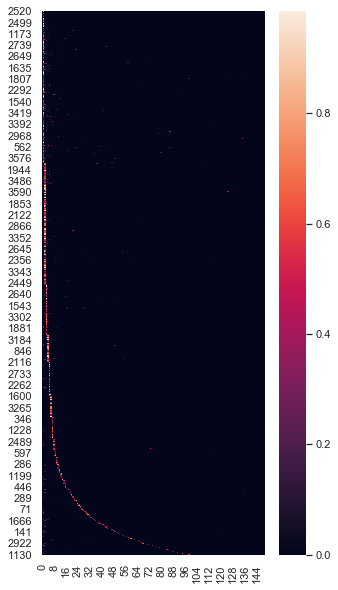

In [97]:
%matplotlib inline
import seaborn as sns; 
sns.set(rc={'figure.figsize':(5,10)})
sns.heatmap(documents2topics.loc[documents2topics.idxmax(axis=1).sort_values().index])

### Filtering the topics 

**Idea**: filter out "bad" topics, so as to retain only the topics pertinent to the collection. <br>
Definition of bad: topics whose max weight across all the documents is below a tbd threshold.

**Also**: we could try filter out the topics that are "too general", where the measure of generality is a function of the number of documents they appear and their respective weights there. 

**Note**: we probably need to re-adjust mixing weights after the filtering.

In [113]:
sum(documents2topics.max(axis=0).sort_values() == 0) # number of topics not appearing in ANY document 

17

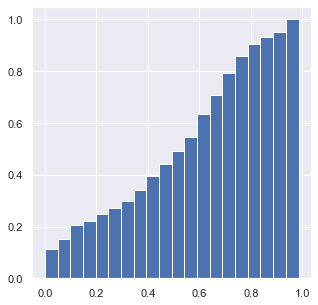

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
h= plt.hist(documents2topics.max(axis=0).sort_values(), bins=20, density=True, cumulative=True) 
plt.show(h)

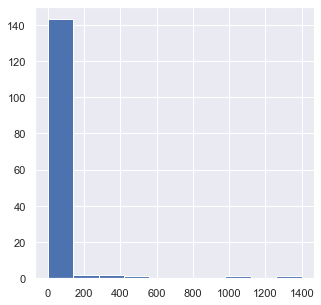

In [124]:
plt.figure(figsize=(5,5))
h= plt.hist(documents2topics.astype(bool).sum(axis=0)) 
plt.show(h)

In [135]:
documents2topics.loc[:,(documents2topics.astype(bool).sum(axis=0) > 400)]

,1,2,3
0,0.000000,0.000000,0.000000
1,0.000000,0.299465,0.000000
2,0.016058,0.010585,0.000000
3,0.000000,0.149653,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
3628,0.396735,0.000000,0.000000
3629,0.000000,0.000000,0.749237
3630,0.000000,0.000000,0.000000
3631,0.000000,0.882028,0.000000


### Updating the model - online step

In [199]:
dictionary2, corpus2 = prepare_gensim_input(set2_docs, old_dict=dictionary1)
# hdp.evaluate_test_corpus(test_corpus) - Returns the value of total likelihood obtained by evaluating the model for all documents in the test corpus.

In [296]:
hdp_new = deepcopy(hdp)

# update the dictionary
hdp_new.id2word = dictionary2

# the m_lambda matrix is a (topic x word) matrix 
# we need to add a new column for each new word before updating the model 
new_words = len(dictionary2)-len(dictionary1) #the new words
# we initialise the new words with weight 0 in the model
m_lambda_new = np.hstack([hdp.m_lambda,np.zeros((150, new_words))])
# TODO: check this with the gensim guys 
hdp_new.m_lambda = m_lambda_new

# the m_Elogbeta matrix is a (topic x word) matrix 
m_Elogbeta_new = np.hstack([hdp.m_Elogbeta,np.zeros((150, new_words))])
hdp_new.m_Elogbeta = m_Elogbeta_new

# the m_timestamp vector is a (wordx1) matrix that 'Helps to keep track and perform lazy updates on lambda.'
m_timestamp_new = np.hstack([hdp.m_timestamp,np.zeros((new_words))]).astype(int)
hdp_new.m_timestamp = m_timestamp_new

In [297]:
hdp_new.update(corpus2)

In [292]:
print_hdp_topics(hdp_new, num_words=10)

Number of topics found: 150

Topic 0 -------
use - model - result - measur - studi - data - differ - effect - system - base

Topic 1 -------
use - model - data - system - base - result - studi - differ - measur - effect

Topic 2 -------
use - model - base - data - measur - result - studi - differ - system - effect

Topic 3 -------
use - model - result - differ - studi - measur - base - data - show - function

Topic 4 -------
model - use - measur - studi - result - effect - differ - observ - base - process

Topic 5 -------
use - model - studi - result - data - base - measur - differ - effect - system

Topic 6 -------
use - model - base - system - method - studi - result - effect - data - show

Topic 7 -------
use - model - result - base - studi - measur - differ - data - effect - method

Topic 8 -------
model - use - increas - result - studi - differ - base - effect - measur - chang

Topic 9 -------
model - use - studi - base - activ - measur - surfac - result - effect - develop

Topic 

In [ ]:
# compute the new topics distribution for the whole collection 
_,corpus_full = prepare_gensim_input(documents, old_dict=dictionary2)
documents2topics_new = docs2topics(hdp_new, corpus_full)

In [245]:
sum(documents2topics_new.max(axis=0).sort_values() == 0) # number of topics not appearing in ANY document (second corpus)

5

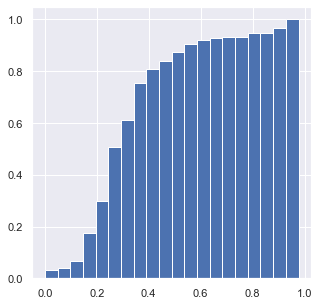

In [249]:
plt.figure(figsize=(5,5))
h= plt.hist(documents2topics_new.max(axis=0).sort_values(), bins=20, density=True, cumulative=True) 
plt.show(h)

In [289]:
# let's have a closer look at the differences btw the old and the new topics distributions 
documents2topics_new.loc[1,:].sort_values(ascending=False)

3      0.730717
149    0.000000
46     0.000000
53     0.000000
52     0.000000
         ...   
99     0.000000
98     0.000000
97     0.000000
96     0.000000
0      0.000000
Name: 0, Length: 150, dtype: float64

In [293]:
hdp_new.print_topic(3)

'0.007*"use" + 0.004*"model" + 0.003*"result" + 0.003*"differ" + 0.003*"studi" + 0.003*"measur" + 0.003*"base" + 0.003*"data" + 0.002*"show" + 0.002*"function"'

In [283]:
documents2topics.loc[0,:].sort_values(ascending=False)

112    0.285818
54     0.000000
52     0.000000
51     0.000000
50     0.000000
         ...   
98     0.000000
97     0.000000
96     0.000000
95     0.000000
0      0.000000
Name: 0, Length: 150, dtype: float64

In [295]:
hdp.print_topic(112)

'0.000*"doubl_blind" + 0.000*"incompet" + 0.000*"slovenian" + 0.000*"roughli" + 0.000*"self_drive" + 0.000*"essenti_tool" + 0.000*"diagnost_interview_high" + 0.000*"polar_entangl" + 0.000*"antar" + 0.000*"approxim_ratio"'